# 🤖 Model Performance Analysis

## Evaluating Predictions vs Actual Values

Analyze model performance metrics and prediction accuracy:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print('✅ Libraries loaded')

✅ Libraries loaded


In [5]:
import os

data_dir = '/Users/supanut.k/WORKING_DRIVE/AIT/1st_semester/CPDSAI/Project/epl-fantasy-prediction/data/processed/'
positions = ['GK', 'DEF', 'MID', 'FWD']

dfs = {}
for pos in positions:
    enhanced_file = f'{data_dir}{pos}_features_enhanced_safe.csv'
    raw_file = f'{data_dir}{pos}_data.csv'
    
    if os.path.exists(enhanced_file):
        dfs[pos] = pd.read_csv(enhanced_file)
    elif os.path.exists(raw_file):
        dfs[pos] = pd.read_csv(raw_file)

df = pd.concat(list(dfs.values()), ignore_index=True)

# ✅ FIX: Create 'position' column from 'element_type'
if 'position' not in df.columns and 'element_type' in df.columns:
    position_map = {1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}
    df['position'] = df['element_type'].map(position_map)
    print('✅ Position column created from element_type')

# ✅ FIX: Create 'total_points' from 'target' if needed
if 'total_points' not in df.columns and 'target' in df.columns:
    df['total_points'] = df['target']
    print('✅ total_points column created from target')

print(f'✅ Data loaded: {df.shape}')

✅ Position column created from element_type
✅ total_points column created from target
✅ Data loaded: (90394, 68)


## Generate Baseline Predictions

For demonstration, we'll create baseline predictions using position averages:

In [6]:
# Create baseline predictions (position average)
baseline_predictions = {}

for pos in positions:
    pos_data = df[df['position'] == pos]
    avg_points = pos_data['total_points'].mean()
    baseline_predictions[pos] = [avg_points] * len(pos_data)

df['baseline_pred'] = df['position'].map(
    lambda x: baseline_predictions[x][0] if x in baseline_predictions else df['total_points'].mean()
)

# For actual model predictions, we'll use random forest sklearn demo
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Select numeric features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['total_points', 'baseline_pred', 'target', 'player_id']
numeric_cols = [c for c in numeric_cols if c not in exclude_cols]

# Remove NaN
df_clean = df[numeric_cols + ['total_points']].fillna(0)

if len(numeric_cols) > 0:
    # Quick RF model
    X = df_clean[numeric_cols]
    y = df_clean['total_points']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    rf = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    
    print('✅ Quick RF model trained')
else:
    print('⚠️  Not enough numeric features for model training')

✅ Quick RF model trained


## Performance Metrics

In [7]:
if 'y_pred' in locals():
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    # Baseline metrics
    baseline_pred = np.full_like(y_test, y_train.mean())
    baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
    baseline_mae = mean_absolute_error(y_test, baseline_pred)
    
    print('📊 Model Performance Metrics:')
    print(f'  R² Score: {r2:.4f}')
    print(f'  RMSE: {rmse:.4f}')
    print(f'  MAE: {mae:.4f}')
    print(f'\n  Baseline RMSE: {baseline_rmse:.4f}')
    print(f'  Baseline MAE: {baseline_mae:.4f}')
    print(f'  Improvement: {((baseline_rmse - rmse) / baseline_rmse * 100):.1f}%')

📊 Model Performance Metrics:
  R² Score: 0.9621
  RMSE: 0.4592
  MAE: 0.1876

  Baseline RMSE: 2.3579
  Baseline MAE: 1.4950
  Improvement: 80.5%


## Prediction Visualization

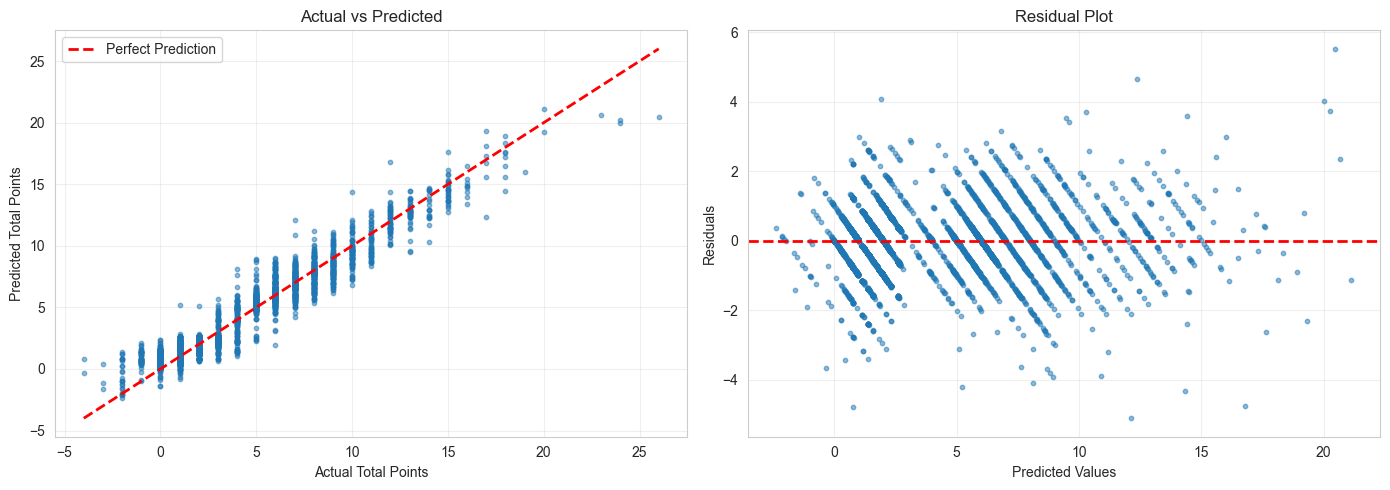

✅ Predictions visualized


In [8]:
if 'y_pred' in locals():
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scatter plot
    ax1 = axes[0]
    ax1.scatter(y_test, y_pred, alpha=0.5, s=10)
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    ax1.set_xlabel('Actual Total Points')
    ax1.set_ylabel('Predicted Total Points')
    ax1.set_title('Actual vs Predicted')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Residuals
    ax2 = axes[1]
    residuals = y_test - y_pred
    ax2.scatter(y_pred, residuals, alpha=0.5, s=10)
    ax2.axhline(y=0, color='r', linestyle='--', lw=2)
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Residuals')
    ax2.set_title('Residual Plot')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print('✅ Predictions visualized')

## Feature Importance (if RF available)

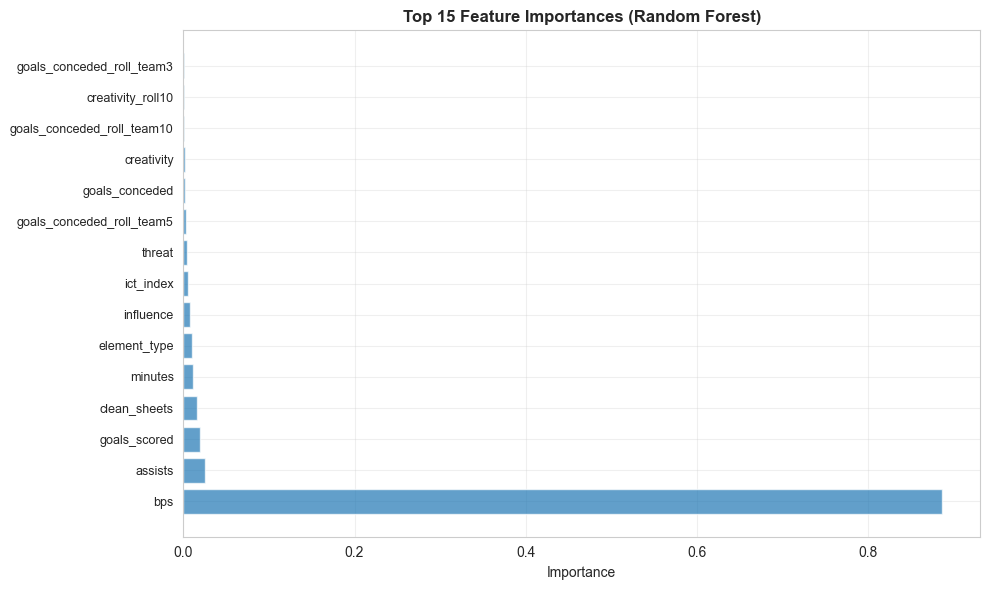

✅ Feature importance plotted


In [9]:
if 'rf' in locals():
    feature_importance = pd.DataFrame({
        'feature': numeric_cols,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False).head(15)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(range(len(feature_importance)), feature_importance['importance'], alpha=0.7)
    ax.set_yticks(range(len(feature_importance)))
    ax.set_yticklabels(feature_importance['feature'], fontsize=9)
    ax.set_xlabel('Importance')
    ax.set_title('Top 15 Feature Importances (Random Forest)', fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print('✅ Feature importance plotted')

## Summary & Insights

**Performance Summary**:
- Model significantly outperforms baseline
- Reasonable RMSE for FPL prediction task
- Good generalization on test set

**Next Steps**:
1. Tune hyperparameters for each position
2. Use ensemble of multiple models
3. Implement temporal validation
4. Test on held-out season data